In [ ]:
!pip install -qU langgraph langchain openai tavily-python langchain_openai langchain_community

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'
os.environ['TAVILY_API_KEY'] = 'YOUR_TAVILY_API_KEY'

# Language Agent Tree Search

**Language Agent Tree Search (LATS)** is a general LLM agent search algorithm that combines reflection/evaluation and search (specifically monte-carlo trees search) to achieve better overall task performance compared to a similar techniques like ReACT, Reflexion, or Tree of Thoughts.

The Language Agent Tree Search has four main steps:
1. **Select**: pick the best next actions based on the aggregate rewards from Step (2). Either respond (if a solution is found or the max search depth is reached) or continue searching.
2. **Expand and simulate**: select the "best" 5 potential actions to take and execute them in parallel.
3. **Reflect + Evaluate**: observe the outcomes of these actions and score the decisions based on reflection (and possibly external feedback).
4 **Backpropagate**: update the scores of the root trajectories based on the outcomes.

# Graph State

LATS is based on a (greedy) Monte-Carlo tree search. For each search steps, it picks the node with the highest "upper confidence bound", which is a metric that balances exploitation (highest average reward) and exploration (lowest visits).

Starting from that node, it generates N new candidate actions to take, and adds them to the tree. It stops searching either when it has generated a valid solution OR when it has reached the maximum number of rollouts (search tree depth).

Our Graph state will be composed of two items:
1. The root of the search tree, and
2. The user input.

In [3]:
import math
from collections import deque
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

In [4]:
class Reflection(BaseModel):
    reflections: str = Field(
        description="The critique and reflections on the sufficiency, superfluency,"
        " and general quality of the response"
    )
    score: int = Field(
        description="Score from 0-10 on the quality of the candidate response.",
        gte=0,
        lte=10,
    )
    found_solution: bool = Field(
        description='Whether the response has fully solved the question or task.'
    )

    def as_message(self):
        return HumanMessage(
            content=f"Reasoning: {self.reflections}\nScore: {self.score}"
        )

    @property
    def normalized_score(self) -> float:
        return self.score / 10

In [33]:
class Node:
    def __init__(
        self,
        messages: list[BaseMessage],
        reflection: Reflection,
        parent: Optional["Node"] = None,
    ):
        self.messages = messages
        self.parent = parent
        self.children = []
        self.value = 0
        self.visits = 0
        self.reflection = reflection
        self.depth = parent.depth + 1 if parent is not None else 1
        self._is_solved = reflection.found_solution if reflection else False

        if self._is_solved:
            self._mark_tree_as_solved()

        self.backpropagate(reflection.normalized_score)


    def __repr__(self) -> str:
        return (
            f"<Node value={self.value}, visits={self.visits},"
            f" solution={self.messages} reflection={self.reflection}/>"
        )



    def _mark_tree_as_solved(self):
        parent = self.parent
        while parent:
            parent._is_solved = True
            parent = parent.parent

    def backpropagate(self, reward: float):
        """Update the score of this node and its parents"""
        node = self
        while node:
            node.visits += 1
            node.value = (node.value * (node.visits - 1) + reward) / node.visits
            node = node.parent


    @property
    def is_solved(self):
        """If any solutions exist, we can end the search"""
        return self._is_solved

    @property
    def is_terminal(self):
        return not self.children

    @property
    def best_child_score(self):
        """Return the child with the highest score"""
        if not self.children:
            return None

        return max(self.children, key=lambda child: int(child.is_solved) * child.value)

    @property
    def height(self) -> int:
        """Check for how far we have rolled out the tree"""
        if self.children:
            return 1 + max([child.height for child in self.children])
        return 1


    def upper_confidence_bound(self, exploration_weight=1.0):
        """Return the upper confidence bound score.
        This helps balance exploration vs. exploitation of a branch"""
        if self.parent is None:
            raise ValueError("Cannot obtain upper confidence bound of root node")
        if self.visits == 0:
            return self.value

        # Encourage exploitation of high-value trajectories
        average_reward = self.value / self.visits

        # Encourage exploration of less-visits trajectories
        exploration_term = math.sqrt(math.log(self.parent.visits) / self.visits)

        return average_reward + exploration_weight * exploration_term


    def get_messages(self, include_reflections: bool = True):
        if include_reflections:
            return self.messages + [self.reflection.as_message()]

        return self.messages


    def get_trajectory(self, include_reflections: bool = True) -> list[BaseMessage]:
        """Get messages representing this search branch"""
        messages = []
        node = self

        while node:
            messages.extend(
                node.get_messages(include_reflections=include_reflections)[::-1]
            )
            node = node.parent

        # Reverse the final back-tracked trajectory to return the correct order
        return messages[::-1] # root solution, reflection, child 1, ...

    def _get_all_children(self):
        all_nodes = []
        nodes = deque()
        nodes.append(self)

        while nodes:
            node = nodes.popleft()
            all_nodes.extend(node.children)
            for n in node.children:
                nodes.append(n)

        return all_nodes


    def get_best_solution(self):
        """Return the best solution from within the current sub-tree"""
        all_nodes = [self] + self._get_all_children()
        best_node = max(
            all_nodes,
            # Filter out all non-terminal, non-solution trajectories
            key=lambda node: int(node.is_terminal and node.is_solved) * node.value,
        )

        return best_node

## The graph state itself

The main component is the tree, represented by the root node.

In [34]:
from typing_extensions import TypedDict

class TreeState(TypedDict):
    # The full tree
    root: Node
    # The original input
    input: str

# Define Language Agent

Our agent will have three primary LLM-powered processes:
1. **Reflect**: score the action based on the tool response.
2. **Initial response**: to create the root node and start the search.
3. **Expand**: generate 5 candidate "next steps" from the best spot in the current tree.

In [35]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

## Tools

In [36]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt import ToolNode

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

tools = [tavily_tool]
tool_node = ToolNode(tools=tools)

## Reflection

The reflection chain will score agent outputs based on the decision and the tool responses. We will call this within the other two nodes.

In [37]:
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser, PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable


prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'Reflect and grade the assistant response to the user question below.',
        ),
        (
            'user',
            '{input}',
        ),
        MessagesPlaceholder(variable_name='candidate'),
    ]
)

reflection_llm_chain = (
    prompt
    | llm.bind_tools(tools=[Reflection], tool_choice='Reflection').with_config(
        run_name='Reflection'
    )
    | PydanticToolsParser(tools=[Reflection])
)


@as_runnable
def reflection_chain(inputs) -> Reflection:
    tool_choices = reflection_llm_chain.invoke(inputs)
    reflection = tool_choices[0]

    if not isinstance(inputs['candidate'][-1], AIMessage):
        reflection.found_solution = False

    return reflection

## Initial Response

We start with a single root node, generated by this first step. It responds to the user input either with a tool invocation or a response.

In [38]:
from langchain_core.prompt_values import ChatPromptValue
from langchain_core.runnables import RunnableConfig

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are an AI assistant',
        ),
        (
            'user',
            '{input}',
        ),
        MessagesPlaceholder(variable_name='messages', optional=True),
    ]
)

initial_answer_chain = (
    prompt_template
    | llm.bind_tools(tools=tools).with_config(
        run_name='GenerateInitialCandidate'
    )
)

parser = JsonOutputToolsParser(return_id=True)

In [39]:
initial_response = initial_answer_chain.invoke(
    {'input': "Write a research report on lithium pollution."}
)

initial_response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hXQlu5NTeSKSB1dDw6r2Vjlb', 'function': {'arguments': '{"query":"lithium pollution research report"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 93, 'total_tokens': 116, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ecdd92da-de03-45c1-a8a9-bd151f6348ef-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'lithium pollution research report'}, 'id': 'call_hXQlu5NTeSKSB1dDw6r2Vjlb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 93, 'output_tokens': 23, 'total_tokens': 116, 'input_token_deta

### Starting Node

We will package up the candidate generation and reflection in a single node of our graph.

In [40]:
# Define the node
def generate_initial_response(state: TreeState) -> dict:
    """Generate the initial candidate response"""
    res = initial_answer_chain.invoke({'input': state['input']})
    parsed = parser.invoke(res)

    tool_responses = [
        tool_node.invoke(
            {
                'messages': [
                    AIMessage(
                        content="",
                        tool_calls=[
                            {
                                'name': r['type'],
                                'args': r['args'],
                                'id': r['id'],
                            }
                        ]
                    )
                ]
            }
        )
        for r in parsed
    ]

    output_messages = [res] + [tr['messages'][0] for tr in tool_responses]

    reflection = reflection_chain.invoke(
        {
            'input': state['input'],
            'candidate': output_messages,
        }
    )

    root = Node(output_messages, reflection=reflection)

    return {**state, 'root': root}

## Candidate Generation

We now use the same LLM to generate N additional candidates to check.

In [41]:
# This generates N candidate values
# for a single input to sample actions from the environment
def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):
    n = config['configurable'].get("N", 5)
    bound_kwargs = llm.bind_tools(tools=tools).kwargs

    chat_result = llm.generate(
        [messages.to_messages()],
        n=n,
        callbacks=config['callbacks'],
        run_name='GenerateCandidates',
        **bound_kwargs,
    )

    return [gen.message for gen in chat_result.generations[0]]


expansion_chain = prompt_template | generate_candidates

In [42]:
res = expansion_chain.invoke(
    {'input': "Write a research report on lithium pollution."}
)
res

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b7AWGy5InOfSnoQepEhdXGCg', 'function': {'arguments': '{"query":"lithium pollution research report"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'finish_reason': 'tool_calls', 'logprobs': None}, id='run-13b6b6d2-dbde-4f1b-ad41-dd636e76e18b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'lithium pollution research report'}, 'id': 'call_b7AWGy5InOfSnoQepEhdXGCg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 93, 'output_tokens': 115, 'total_tokens': 208, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b7AWGy5InOfSnoQepEhdXGCg', 'function': {'arguments': '{"query":"lithium pollution research report"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'to

### Candidate generation node

We will package the candidate generation and reflection steps in the following `expand` node. We will do all the operations as a batch process to speed up execution.

In [43]:
from collections import defaultdict


def select(root: Node) -> dict:
    """Starting from the root node,
    a child node is selected at each tree level until a leaf node is reached
    """
    if not root.children:
        return root

    node = root
    while node.children:
        max_child = max(node.children, key=lambda child: child.upper_confidence_bound())
        node = max_child

    return node


def expand(state: TreeState, config: RunnableConfig) -> dict:
    """Starting from the "best" node in the tree,
    generate N candidates for the next step.
    """
    root = state['root']
    best_candidate: Node = select(root)
    messages = best_candidate.get_trajectory()

    # Generate N candidates from the single child candidate
    new_candidates = expansion_chain.invoke(
        {
            'input': state['input'],
            'messages': messages,
        },
        config
    )
    parsed = parser.batch(new_candidates)

    flattened = [
        (i, tool_call)
        for i, tool_calls in enumerate(parsed)
        for tool_call in tool_calls
    ]

    tool_responses = [
        (
            i,
            tool_node.invoke(
                {
                    'messages': [
                        AIMessage(
                            content="",
                            tool_calls=[
                                {
                                    'name': tool_call['type'],
                                    'args': tool_call['args'],
                                    'id': tool_call['id'],
                                }
                            ],
                        )
                    ]
                }
            ),
        )
        for i, tool_call in flattened
    ]

    collected_responses = defaultdict(list)
    for i, resp in tool_responses:
        collected_responses[i].append(resp['messages'][0])

    output_messages = []
    for i, candidate in enumerate(new_candidates):
        output_messages.append([candidate] + collected_responses[i])


    # Reflect on each candidate
    # For tasks with external validation, we'd add things here
    reflections = reflection_chain.batch(
        [{'input': state['input'], 'candidate': msgs} for msgs in output_messages],
        config,
    )

    # Grow tree
    child_nodes = [
        Node(cand, parent=best_candidate, reflection=reflection)
        for cand, reflection in zip(output_messages, reflections)
    ]
    best_candidate.children.extend(child_nodes)

    # We have extended the tree above, so only return the state
    return state

# Create Graph

In [44]:
from typing import Literal

from langgraph.graph import START, END, StateGraph


def should_loop(state: TreeState):
    """Determine whether to continue the tree search"""
    root = state['root']

    if root.is_solved:
        return END
    if root.height > 5:
        return END

    return "expand"

In [45]:
builder = StateGraph(TreeState)
# Add nodes
builder.add_node('start', generate_initial_response)
builder.add_node('expand', expand)
# Add edges
builder.add_edge(START, 'start')
builder.add_conditional_edges(
    'start',
    # Either expand/rollout or finish
    should_loop,
    ['expand', END],
)
builder.add_conditional_edges(
    'expand',
    # Either continue to rollout or finish
    should_loop,
    ['expand', END],
)

graph = builder.compile()

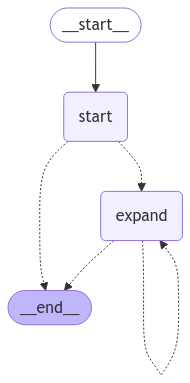

In [46]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Invoke

In [47]:
question = """Generate a table with the average size and weight,
            as well as the oldest recorded instance for each of the top 5 most common birds.
        """

last_step = None
for step in graph.stream({"input": question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")

start
rolled out:  1
---
expand
rolled out:  2
---


In [48]:
solution_node = last_step["expand"]["root"].get_best_solution()
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

Based on the information gathered, here is a table summarizing the average size and weight, as well as the oldest recorded instance for each of the top 5 most common birds:

| Bird Species         | Average Size (Length) | Average Weight | Oldest Recorded Instance |
|----------------------|----------------------|----------------|--------------------------|
| Domestic Chicken     | 45-50 cm             | 1.5-4 kg       | 16 years                  |
| Red-billed Quelea    | 12-13 cm             | 30-40 g        | 4 years                   |
| Common Starling      | 20-23 cm             | 60-100 g       | 15 years                  |
| House Sparrow        | 14-16 cm             | 24-39 g        | 13 years                  |
| Barn Swallow         | 14-20 cm             | 16-20 g        | 8 years                   |

### Notes:
- The size and weight ranges are averages and can vary based on individual birds and their specific environments.
- The oldest recorded instances are approximate an

In [49]:
question = "Write out magnus carlson series of moves in his game against Alireza Firouzja and propose an alternate strategy"
last_step = None
for step in graph.stream({"input": question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")

start
rolled out:  1
---
expand
rolled out:  2
---
expand
rolled out:  3
---


In [50]:
solution_node = last_step["expand"]["root"].get_best_solution()
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

### Magnus Carlsen vs. Alireza Firouzja: Move List

**Game:** SpeedChess Final 2024  
**Opening:** French, Exchange Variation (C01)  
**Result:** 1-0  

1. e4 e6  
2. d4 d5  
3. exd5 exd5  
4. Nf3 Bd6  
5. c4 Nf6  
6. c5 Be7  
7. h3 O-O  
8. Bd3 Nc6  
9. O-O Ne4  
10. Nc3 Bf5  
11. Re1 Bf6  
12. Nxe4 dxe4  
13. Bxe4 Bxe4  
14. Rxe4 Qd5  
15. Rf4 Rad8  
16. Be3 Rfe8  
17. Qc2 Nb4  
1-0

In this game, Carlsen displayed his strategic prowess by maintaining a slight material advantage and managing the board effectively, eventually converting it into a win.

### Proposed Alternate Strategy

In analyzing the game, an alternate strategy for Firouzja could involve a more aggressive approach in the opening phase, particularly from move 6 onwards. Instead of playing 6...Be7, which is more passive, he could have considered:

**6...f5:**  
This move aims to take control of the center and create potential threats against White's kingside. It allows for more dynamic piece play and can lead to more t